<a href="https://colab.research.google.com/github/neuralsrg/SequenceModels/blob/main/triger_word_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Triger word detection with RNN 

In [ ]:
! pip install pydub

In [ ]:
import numpy as np 
import tensorflow as tf 
import matplotlib.pyplot as plt 
import os 
from scipy.io import wavfile
from pydub import AudioSegment
from IPython import display
import librosa
import librosa.display
from glob import glob
import collections

from google.colab import drive
drive.mount('/content/drive')

## Time-Frequency domain 


In [3]:
def plot_spectrogram(path : str,
                     sr : int = 44100,
                     n_fft : int = 256,
                     hop_length : int = 64, y_axis='log'):
  x, sample_rate = librosa.load(path, sr=sr)
  x = np.abs(librosa.stft(x, n_fft=n_fft, hop_length=hop_length))
  plt.figure(figsize=(16, 8))
  x = librosa.power_to_db(x)
  librosa.display.specshow(x, sr=sr, hop_length=hop_length, x_axis='time', y_axis=y_axis)
  plt.colorbar()

  return x

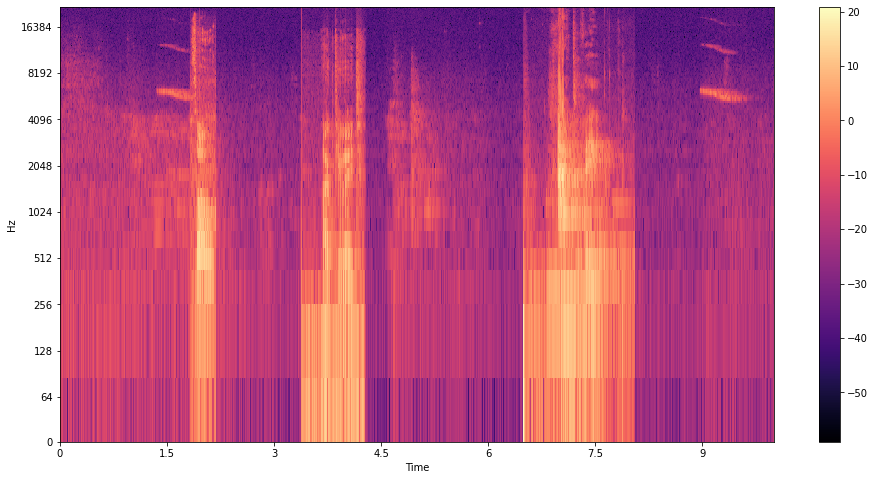

In [ ]:
x = plot_spectrogram('/content/drive/MyDrive/audio_data/audio_examples/example_train.wav')

In [ ]:
print(x.shape)
n_x, Tx = x.shape

(129, 6891)


## Toy Dataset

In [4]:
Ty = 1720 # (conv output)

In [5]:
def load_audio_data(path : str):

  data = collections.defaultdict(list)
  folders = ['activates', 'backgrounds', 'negatives']

  for folder in folders:
    for filename in glob(os.path.join(path, folder, '*.wav')):
      signal = AudioSegment.from_wav(filename)
      data[folder].append(signal)

  return data

In [6]:
raw_data = load_audio_data('/content/drive/MyDrive/audio_data/raw_data')

### Combining background audios with words

In [7]:
def insert_audio_clip(background, audio_clip, previous_segments):
  """
  Insert a new audio segment over the background noise at a random time step, ensuring that the 
  audio segment does not overlap with existing segments.
  
  Arguments:
  background -- a 10 second background audio recording.  
  audio_clip -- the audio clip to be inserted/overlaid. 
  previous_segments -- times where audio segments have already been placed
  
  Returns:
  new_background -- the updated background audio
  """


  def get_random_time_segment(segment_ms):
      
    segment_start = np.random.randint(low=0, high=10000-segment_ms)
    segment_end = segment_start + segment_ms - 1
    
    return (segment_start, segment_end)


  def is_overlapping(segment_time, previous_segments):
      
    segment_start, segment_end = segment_time
    overlap = False
    
    for previous_start, previous_end in previous_segments:
      if segment_start <= previous_end and segment_end >= previous_start:
        overlap = True
        break
  
    return overlap
  

  segment_ms = len(audio_clip)
  segment_time = get_random_time_segment(segment_ms)
  
  retry = 5
  while is_overlapping(segment_time, previous_segments) and retry >= 0:
    segment_time = get_random_time_segment(segment_ms)
    retry = retry - 1

  if not is_overlapping(segment_time, previous_segments):
    previous_segments.append(segment_time)
    new_background = background.overlay(audio_clip, position=segment_time[0])
    print(segment_time)
  else:
    print("Timeouted")
    new_background = background
    segment_time = (10000, 10000)
  
  return new_background, segment_time


def relabel(y, segment_end_ms):
  _, Ty = y.shape
  segment_start_y = int(segment_end_ms * Ty / 10000.0) + 1
  if segment_start_y >= 10000:
    return y
  segment_end_y = segment_start_y + 50 if segment_start_y + 50 <= 10000 else 10000

  y[0, segment_start_y : segment_end_y] = 1
  return y

In [8]:
def create_training_example(background, activates, negatives, Ty):
    """
    Creates a training example with a given background, activates, and negatives.
    
    Arguments:
    background -- a 10 second background audio recording
    activates -- a list of audio segments of the word "activate"
    negatives -- a list of audio segments of random words that are not "activate"
    Ty -- The number of time steps in the output

    Returns:
    x -- the spectrogram of the training example
    y -- the label at each time step of the spectrogram
    """

    def match_target_amplitude(sound, target_dBFS):
      change_in_dBFS = target_dBFS - sound.dBFS
      return sound.apply_gain(change_in_dBFS)
    
    # Make background quieter
    background = background - 20

    y = np.zeros((1, Ty))
    previous_segments = []
    
    number_of_activates = np.random.randint(0, 5)
    random_indices = np.random.randint(len(activates), size=number_of_activates)
    random_activates = [activates[i] for i in random_indices]
    
    for random_activate in random_activates:

      background, segment_time = insert_audio_clip(background, random_activate, previous_segments)
      segment_start, segment_end = segment_time
      y = relabel(y, segment_end)

    number_of_negatives = np.random.randint(0, 3)
    random_indices = np.random.randint(len(negatives), size=number_of_negatives)
    random_negatives = [negatives[i] for i in random_indices]

    for random_negative in random_negatives:

      background, _ = insert_audio_clip(background, random_negative, previous_segments)
    
    background = match_target_amplitude(background, -20.0)

    file_handle = background.export("train" + ".wav", format="wav")
    x = plot_spectrogram("train.wav")
    
    return x, y

In [ ]:
nsamples = 32
X = []
Y = []
for i in range(0, nsamples):
  if i%10 == 0:
      print(i)
  x, y = create_training_example(raw_data['backgrounds'][i % 2],
                                  raw_data['activates'], raw_data['negatives'],
                                  Ty)
  X.append(x.swapaxes(0,1))
  Y.append(y.swapaxes(0,1))
X = np.array(X)
Y = np.array(Y)

In [15]:
Tx, n_x = X.shape[1], X.shape[2]
Ty, n_y = Y.shape[1], Y.shape[2]

X.shape, Y.shape

((32, 6891, 129), (32, 1720, 1))

## Model


![image](https://i.imgur.com/Yby2Iic.png)

In [18]:
def create_model(input_shape):
  input = tf.keras.layers.Input(shape=input_shape)
  x = tf.keras.layers.Conv1D(filters=196, kernel_size=15, strides=4)(input)
  x = tf.keras.layers.BatchNormalization()(x) # axis=-1
  x = tf.keras.layers.Activation('relu')(x)
  x = tf.keras.layers.Dropout(rate=0.2)(x)

  x = tf.keras.layers.GRU(units=128, return_sequences=True)(x)
  x = tf.keras.layers.Dropout(rate=0.2)(x)
  x = tf.keras.layers.BatchNormalization()(x) # axis=-1

  x = tf.keras.layers.GRU(units=128, return_sequences=True)(x)
  x = tf.keras.layers.Dropout(rate=0.2)(x)
  x = tf.keras.layers.BatchNormalization()(x) # axis=-1
  x = tf.keras.layers.Dropout(rate=0.2)(x)

  # same as tf.keras.TimeDistributed(Dense) in case of Dense
  x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

  return tf.keras.Model(inputs=input, outputs=x)

In [19]:
model = create_model((Tx, n_x))
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 6891, 129)]       0         
                                                                 
 conv1d_1 (Conv1D)           (None, 1720, 196)         379456    
                                                                 
 batch_normalization_1 (Batc  (None, 1720, 196)        784       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 1720, 196)         0         
                                                                 
 dropout (Dropout)           (None, 1720, 196)         0         
                                                                 
 gru (GRU)                   (None, 1720, 128)         125184    
                                                             

The only thing left to do is to train the model on a **big** dataset for couple hours on GPU